In [1]:
import skimage.io as io
import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
import os
import time

Hyperparameters

In [2]:
crop_size = 400, 400
patch_size = 100, 100
n_scale = 2
patch_overlap = 0.5
n_classes = 7

Listing images and masks

In [3]:
dataset_name = 'grss2014'
img_names = os.listdir(os.path.join(dataset_name, 'images'))
mask_names = os.listdir(os.path.join(dataset_name, 'masks'))
ignore_set = ['test.ppm', 'val.ppm']


for ignore in ignore_set:
    img_names.remove(ignore)
    mask_names.remove(ignore.replace('.ppm', '.tif'))
print(img_names)
print(mask_names)

['train.ppm']
['train.tif']


Calculating class percentage

In [4]:
class_samples = np.zeros(n_classes)
d = {}
for msk in mask_names:
    mask = plt.imread(os.path.join(dataset_name, 'masks', msk))[:,:,:-1]
    mask = mask.reshape(-1, 3)
    pixel, count = np.unique(mask, axis=0, return_counts=True)
    for p, c in zip(pixel, count):
        if tuple(p) in d:
            d[tuple(p)] += c
        else:
            d[tuple(p)] = c
    d.pop((0,0,0))
print(d) 

{(0, 255, 0): 27700, (0, 255, 255): 53520, (46, 139, 87): 185329, (160, 32, 240): 97826, (255, 0, 0): 46578, (255, 0, 255): 112457, (255, 255, 0): 44738}


In [5]:
class_proportion = {}
s = sum(d.values())
for k, v in d.items():
    pct = v * 100.0 / s
    class_proportion[k] = pct
    
print('Proportion: ', class_proportion)

max_class = max(class_proportion.values())
class_weight = {}
for k, v in class_proportion.items():
    class_weight[k] = max_class/v
    
print('Class weight: ', class_weight)

Proportion:  {(0, 255, 0): 4.87549018917606, (0, 255, 255): 9.420080683202265, (46, 139, 87): 32.61984553320614, (160, 32, 240): 17.21840083921795, (255, 0, 0): 8.19821595781381, (255, 0, 255): 19.793610115674085, (255, 255, 0): 7.8743566817096955}
Class weight:  {(0, 255, 0): 6.69057761732852, (0, 255, 255): 3.4627989536621824, (46, 139, 87): 1.0, (160, 32, 240): 1.8944759062008056, (255, 0, 0): 3.9788956159560307, (255, 0, 255): 1.6479987906488704, (255, 255, 0): 4.1425410165854535}


<BarContainer object of 7 artists>

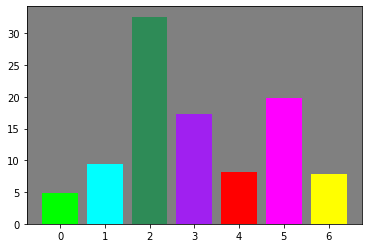

In [6]:
plt.rcParams['axes.facecolor'] = 'gray'
colors = [(a/255.,b/255.,c/255.) for a,b,c in class_proportion.keys()]
plt.bar(range(n_classes), class_proportion.values(), color=colors)

Gini index calculation

In [8]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    aux = array.reshape(-1, 3)
    filtered = aux[(aux != [0,0,0]).any(axis=1)]
    unique = np.unique(filtered, axis=0)
    d = {}
    for cont, u in enumerate(unique):
        d[tuple(u)] = cont+1
    new = np.zeros(filtered.shape[0])
    for key in d.keys():
        new[np.where((filtered == key).all(axis=1))] = d[key]
    array = new
    
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [9]:
mean_gini = 0
for msk in mask_names:
    print(msk, end="\r", flush=True)
    mask = plt.imread(os.path.join(dataset_name, 'masks', msk))[:,:,:-1].reshape(-1,3)
    mean_gini += gini(mask)
    
mean_gini /= len(mask_names)
print()
print(mean_gini)

train.tif
0.2271379970440583


Patches' probabilities preparation

In [25]:
def calculate_prob(patch, class_weight):
    patch = patch.reshape(-1, 3)
    pixel, count = np.unique(patch, axis=0, return_counts=True)
    prob = 0
    for p, c in zip(pixel, count):
        if list(p) != [0, 0, 0]:
            prob += class_weight[tuple(p)] * c
        
    return prob
    
    
def generate_patch_probs(mask_name, mask, patch_size, patch_overlap, class_weight, scale):
    probs = []
    row = 0
    col = 0
    max_row, max_col, _ = mask.shape
    p_size = (patch_size[0]*scale, patch_size[1]*scale)
    while row < max_row - p_size[0]:
        col = 0
        while col < max_col - p_size[1]:
            row_end = row + p_size[0]
            col_end = col + p_size[1]
            patch = mask[row:row_end, col:col_end, :]
            prob = calculate_prob(patch, class_weight)
            if prob != 0:
                probs.append((mask_name, prob, row, p_size[0], col, p_size[0]))
            col += int(p_size[1]*(1-patch_overlap))
        row += int(p_size[0]*(1-patch_overlap))
    return probs

In [26]:
# patch_prob = [(img_name, value, start_row, row_size, start_col, col_size)]
patch_prob = {}
for scale in range(1, n_scale + 1):
    patch_prob[scale] = []
    for mask_name in mask_names:
        print(scale, mask_name, end="\r", flush=True)
        mask = plt.imread(os.path.join(dataset_name, 'masks', mask_name))[:,:,:-1]
        patch_prob[scale].extend(generate_patch_probs(mask_name, mask, patch_size, patch_overlap, class_weight, scale))

In [28]:
sum_probs = {}
for scale in range(1, n_scale+1):
    sum_probs[scale] = 0
    for p in patch_prob[scale]:
        sum_probs[scale] += p[1]

Generating new images

In [39]:
def select_patch(prob, prob_sum):
    array = np.array(prob)
    array_prob = array[:,1].astype(np.float)
    array_prob = array_prob/prob_sum
    choice = np.random.choice(len(prob), p=array_prob)
    choice = prob[choice]
    img = io.imread(os.path.join(dataset_name, 'images', choice[0]).replace('.tif', '.ppm'))
    mask = plt.imread(os.path.join(dataset_name, 'masks', choice[0]))[:,:,:-1]
    img_patch = img[choice[2] : choice[2] + choice[3], 
                    choice[4] : choice[4] + choice[5], :]
    mask_patch = mask[choice[2] : choice[2] + choice[3], 
                    choice[4] : choice[4] + choice[5], :]
    return img_patch, mask_patch

def transform_patch(img, mask):
    aug = A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        #A.Rotate(p=0.5),
        A.Transpose(p=0.5),
        A.OneOf([
            #A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.8),
            A.Perspective(p=0.8),
            #A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.5)])

    augmented = aug(image=img, mask=mask)
    image_transformed = augmented['image']
    mask_transformed = augmented['mask']
    
    return image_transformed, mask_transformed

# scale = 2
# a,b = select_patch(patch_prob[scale], sum_probs[scale])
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
# axes[0].imshow(a)
# axes[1].imshow(b)

In [40]:
def generate_image(n_scale, crop_size, p_size):
    scale = random.randint(1, n_scale)
    patch_size = (p_size[0]*scale, p_size[1]*scale)
    new_img = np.zeros((crop_size[0], crop_size[1], 3))
    new_mask = np.zeros((crop_size[0], crop_size[1], 3))
    
    n_rows = crop_size[0]//(patch_size[0])
    n_cols = crop_size[0]//(patch_size[0])
    row = 0
    col = 0
    while row < n_rows:
        if row % 2 == 0:
            col = 0
            while col < n_cols-1:
                img_patch, mask_patch = select_patch(patch_prob[scale], sum_probs[scale])
                img_patch, mask_patch = transform_patch(img_patch, mask_patch)
                row_start = patch_size[0]*row
                row_end = patch_size[0]*row + patch_size[0]
                col_start = patch_size[1]*col
                col_end = patch_size[1]*col + patch_size[1]
                new_img[row_start:row_end, col_start:col_end, :] = img_patch
                new_mask[row_start:row_end, col_start:col_end, :] = mask_patch

                flip_col_start = col_start+patch_size[1]
                flip_col_end = col_end+patch_size[1]

                new_img[row_start:row_end, flip_col_start:flip_col_end,:] = np.flip(img_patch, 1)
                col += 2
        else:
            col = 1
            while col < n_cols:
                img_patch, mask_patch = select_patch(patch_prob[scale], sum_probs[scale])
                row_start = patch_size[0]*row
                row_end = patch_size[0]*row + patch_size[0]
                col_start = patch_size[1]*col
                col_end = patch_size[1]*col + patch_size[1]
                new_img[row_start:row_end, col_start:col_end, :] = img_patch
                new_mask[row_start:row_end, col_start:col_end, :] = mask_patch

                flip_col_start = col_start-patch_size[1]
                flip_col_end = col_end-patch_size[1]

                new_img[row_start:row_end, flip_col_start:flip_col_end,:] = np.flip(img_patch, 1)
                col += 2
        row += 1

    new_img = new_img.astype(np.uint8)
    new_mask = new_mask.astype(np.uint8)
    
    return new_img, new_mask

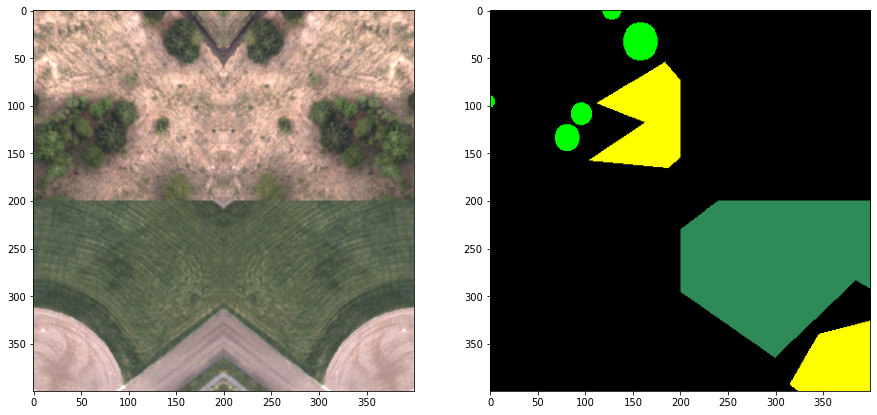

In [41]:
new_img, new_mask = generate_image(n_scale, crop_size, patch_size)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axes[0].imshow(new_img)
axes[1].imshow(new_mask)

In [42]:
#!rm -r new_data
!mkdir grss2014_new_data
!mkdir grss2014_new_data/images
!mkdir grss2014_new_data/masks
!cd grss2014_new_data && ls

images	masks


In [43]:
n_images = 1000
new_images = []
new_masks = []
for i in range(n_images):
    print(i, end="\r", flush=True)
    new_img, new_mask = generate_image(n_scale, crop_size, patch_size)
    new_images.append(new_img)
    new_masks.append(new_mask)

In [46]:
cont = 0
for img, msk in zip(new_images, new_masks):
    io.imsave(os.path.join('grss2014_new_data', 'images', str(cont)+'.png'), img)
    io.imsave(os.path.join('grss2014_new_data', 'masks', str(cont)+'.png'), msk)
    cont += 1 

In [47]:
new_gini = 0
for i, new_mask in enumerate(new_masks):
    print(i, end="\r", flush=True)
    new_gini += gini(new_mask)
    
new_gini /= len(new_masks)
print('\nold: ', mean_gini)
print('new: ', (new_gini+mean_gini)/2)

999
old:  0.2271379970440583
new:  0.20407697116203222
